# Envoirnment Setup

In [1]:
# Load and Preprocessing
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
from PIL import Image, ImageOps
import skimage
from skimage import data
from skimage.util import montage
from skimage.transform import rotate, resize
from sklearn.preprocessing import MinMaxScaler

# Data Splitting
from sklearn.model_selection import train_test_split

# Data Generation & Augmentation
import keras
import keras.backend as K
import tensorflow as tf
import skimage.transform as skTrans
# from tensorflow.keras.layers.experimental import preprocessing

# Model Building
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model

2025-06-17 06:41:17.580383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750142477.848275      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750142477.926589      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Load & Explore the dataset

In [2]:
training_data_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [3]:
# loading .nii file as a numpy array for a test image
test_image_number = "050"
test_image_path = training_data_path + f"BraTS20_Training_{test_image_number}/"
test_image_flair = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_flair.nii").get_fdata()
print(f"{test_image_flair.shape = }")
print(f"{test_image_flair.dtype = }")
print(f"{test_image_flair.min() = }")
print(f"{test_image_flair.max() = }")

test_image_flair.shape = (240, 240, 155)
test_image_flair.dtype = dtype('float64')
test_image_flair.min() = 0.0
test_image_flair.max() = 922.0


As we can see the maximum pixel value of the image is `1854.6` which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale.

This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [4]:
scaler = MinMaxScaler()
scaled_test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1]))
print(f"{scaled_test_image_flair.shape = }")

scaled_test_image_flair.shape = (57600, 155)


After scaling the image, the image shape is changed to `(57600, 155)`.

we need to reshape the image back to its orignal dimensions to ensure that the data is normalized/standardized for the model input without altering its spatial structure.

In [5]:
scaled_test_image_flair = scaled_test_image_flair.reshape(test_image_flair.shape)
print(f"{scaled_test_image_flair.shape = }")
print(f"{scaled_test_image_flair.min() = }")
print(f"{scaled_test_image_flair.max() = }")

scaled_test_image_flair.shape = (240, 240, 155)
scaled_test_image_flair.min() = 0.0
scaled_test_image_flair.max() = 1.0


In [6]:
# After rescaling flair, we need to rescale t1, t1ce and t2
# rescaling t1
test_image_t1 = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t1.nii").get_fdata()
scaled_test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t1ce.nii").get_fdata()
scaled_test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_t2.nii").get_fdata()
scaled_test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(test_image_path + f"BraTS20_Training_{test_image_number}_seg.nii").get_fdata()

Slice Number: 95


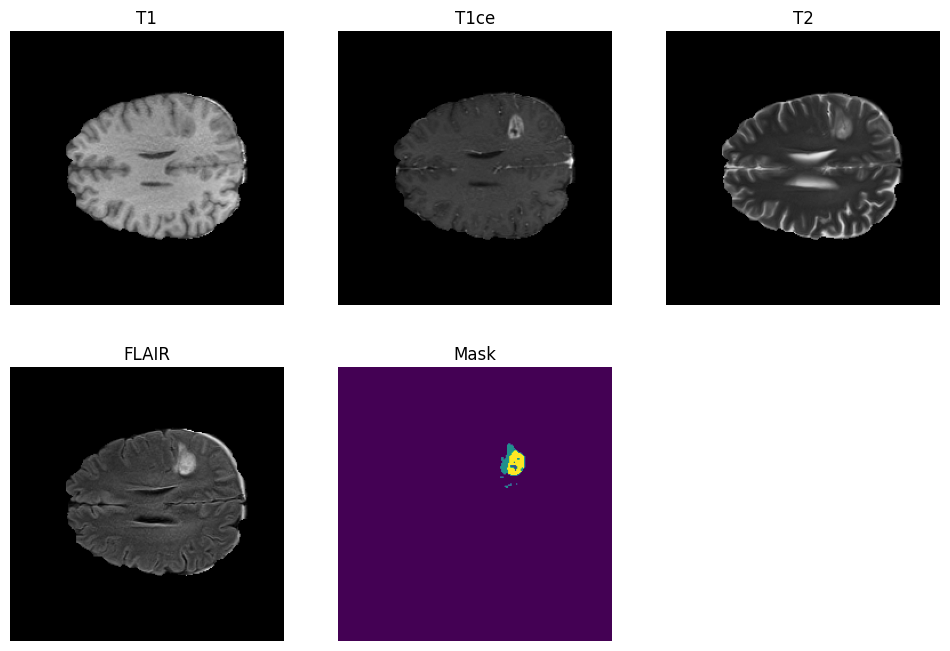

In [7]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(scaled_test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')
plt.axis('off')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(scaled_test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')
plt.axis('off')

# T2
plt.subplot(2, 3, 3)
plt.imshow(scaled_test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')
plt.axis('off')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(scaled_test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')
plt.axis('off')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.axis('off')

plt.show()

When analyzing brain scans, we use four different imaging techniques, or **modalities**, to get a full picture. Each one highlights different aspects of the brain, which helps doctors detect and diagnose abnormalities.

### **Breakdown of the Four Modalities:**  

1. **T1 (Native):** This scan gives a clear view of the brain’s structure, making it useful for spotting things like tumors and cysts.  
2. **T1ce (Post-contrast T1-weighted, aka T1Gd):** It’s similar to T1, but with a contrast agent (Gadolinium) that makes abnormalities stand out even more.  
3. **T2:** This one focuses on fluids in the brain, which can help in identifying swelling or other issues.  
4. **T2-FLAIR (Fluid Attenuated Inversion Recovery):** This scan is like T2, but it suppresses normal fluid signals, making hidden abnormalities (like lesions in white matter) easier to see.  

For doctors, using all four modalities gives the most complete picture for diagnosing brain tumors. However, since we’re working with **AI-based segmentation**, using all four is computationally heavy. To make things more efficient, we can **reduce the number of modalities** while still getting reliable results.  

### **Why We’re Using Only T1ce & T2-FLAIR**  

- We **don’t need T1**, because T1ce (the contrast-enhanced version) already provides a clearer view.  
- We **skip T2**, since its emphasis on fluids might introduce noise and hurt our model’s accuracy.  
- **T2-FLAIR is a better choice** because it removes unnecessary fluid signals, making affected areas stand out more clearly.  

By keeping **T1ce and T2-FLAIR**, we strike a balance between accuracy and efficiency, allowing our AI model to work faster while still making reliable segmentations.


### **Image Format**  

These are **NIfTI (Neuroimaging Informatics Technology Initiative) files**, which are commonly used in medical imaging.  

A **NIfTI image** represents a **3D object**, like a brain, in a digital format. This format is widely used in neuroimaging because it can handle **complex, multi-dimensional data** while also storing important metadata like spatial orientation and scaling.  

To better understand the dataset, let’s check the shape of a **modality scan** and a **segmentation mask**. In this dataset, **all modalities and segmentation masks have the same dimensions**, ensuring consistency across the images.


In [8]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


### **Understanding Image Dimensions and Planes**  

Medical images in this dataset are **3D scans**, meaning they are made up of **a series of 2D slices stacked together**. Each slice has the same resolution and represents a cross-section of the brain. For example, in our previous example, we displayed the **95th slice** of one dimension.  

These 3D scans follow the natural structure of the human body and are divided into **three main planes** used in medical imaging: **axial, coronal, and sagittal**. Each plane provides a unique way of viewing the brain, making it easier to analyze its structure and detect abnormalities.  

### **The Three Planes in Medical Imaging:**  

1. **Axial (Transverse) Plane:**  
   - Think of this as a **top-down view** of the brain.  
   - It slices **horizontally**, dividing the body into **upper and lower** parts.  
   - Used frequently in brain imaging to detect abnormalities from a bird’s-eye perspective.
    

2. **Coronal (Frontal) Plane:**  
   - This gives a **front-facing view**, as if looking at someone head-on.  
   - It slices **vertically from side to side**, splitting the body into **front and back** sections.  
   - Helps in analyzing brain structures from a forward-facing perspective.  

3. **Sagittal (Lateral) Plane:**  
   - Provides a **side view** of the brain.  
   - It slices **vertically from front to back**, dividing the brain into **left and right** halves.  
   - Useful for examining structures along the midline of the brain.  

Understanding these planes is **essential** for working with medical scans because each one offers a different perspective on the brain. By viewing images in multiple planes, we can **better localize abnormalities** and improve the accuracy of segmentation models.  


Slice number: 95


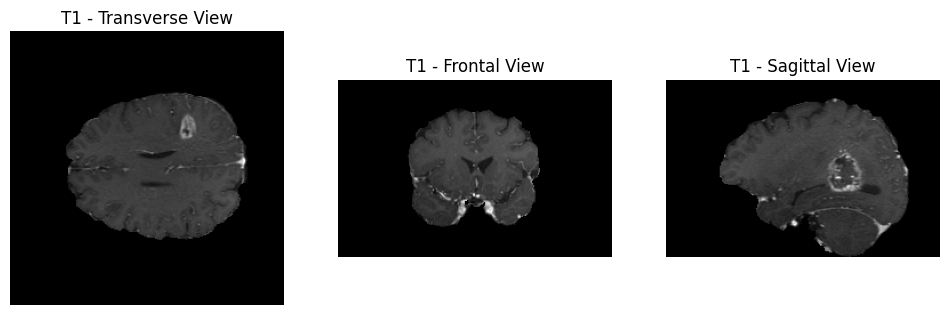

In [9]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')
plt.axis('off')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')
plt.axis('off')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.axis('off')

plt.show()

This visualization helps illustrate how each plane cuts through the brain and highlights different anatomical features, aiding in comprehensive analysis and segmentation.

---
Now that we understand the three dimensions, let's explore why we chose to display a specific slice, setting the slice number to 95. By examining all the slices, we can identify the slice that best represents the region of interest, such as the area where a tumor is located.

To visualize this, we will display all the slices along one dimension:


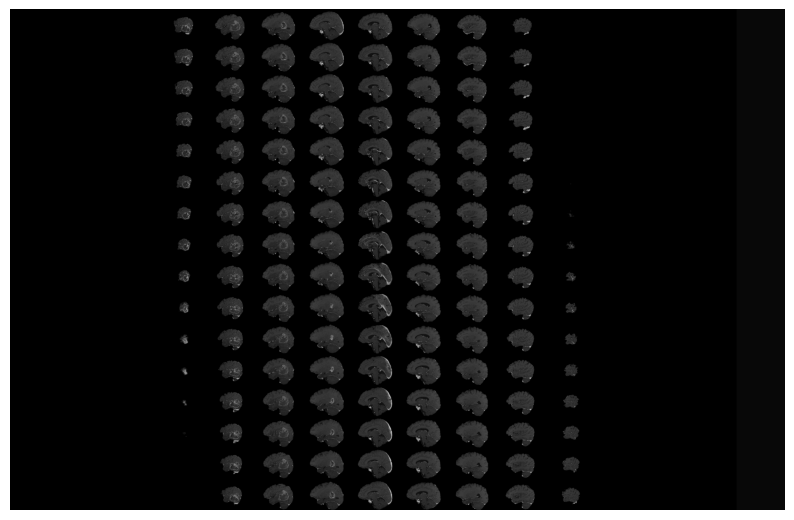

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');
plt.axis('off')
plt.show()

As we can see, two black parts are present on each side of our montage. These black parts correspond to the first and last slices of the plane. This indicates that a large portion of the slices does not contain much information, which is expected as the slices progressively represent the brain from one end to the other.

This observation is consistent across all modalities, planes, and even the expert-segmented images. The experts were unable to segment the slices that lack significant information, as these slices mostly capture areas outside the brain or the outermost regions that do not contain relevant anatomical details.

To further illustrate this, let's visualize a range of slices:

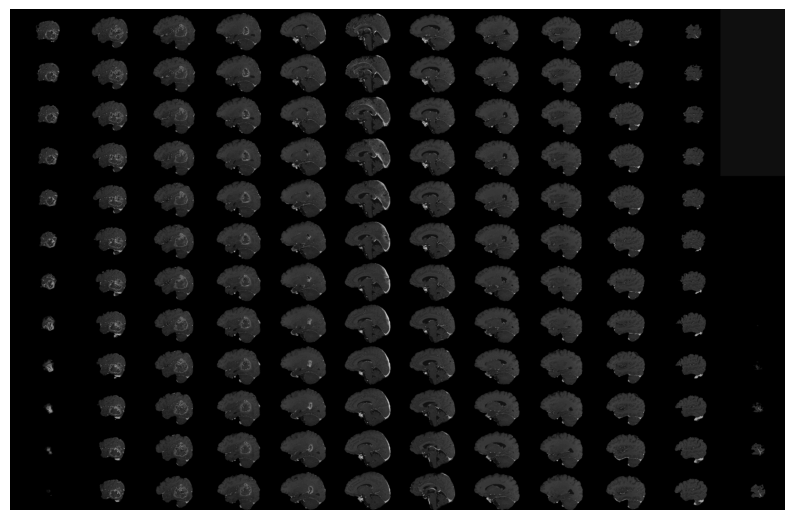

In [11]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');
plt.axis('off')
plt.show()

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

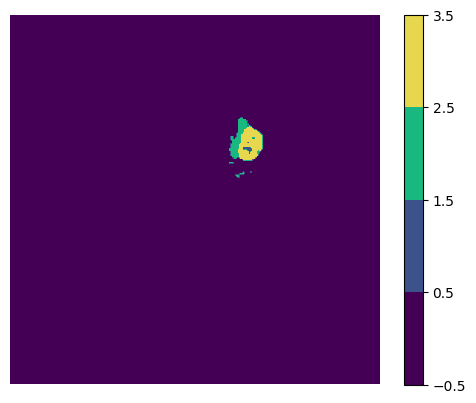

In [12]:
# Plotting the segmantation
cmap = mlt.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mlt.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.axis('off')
plt.show()

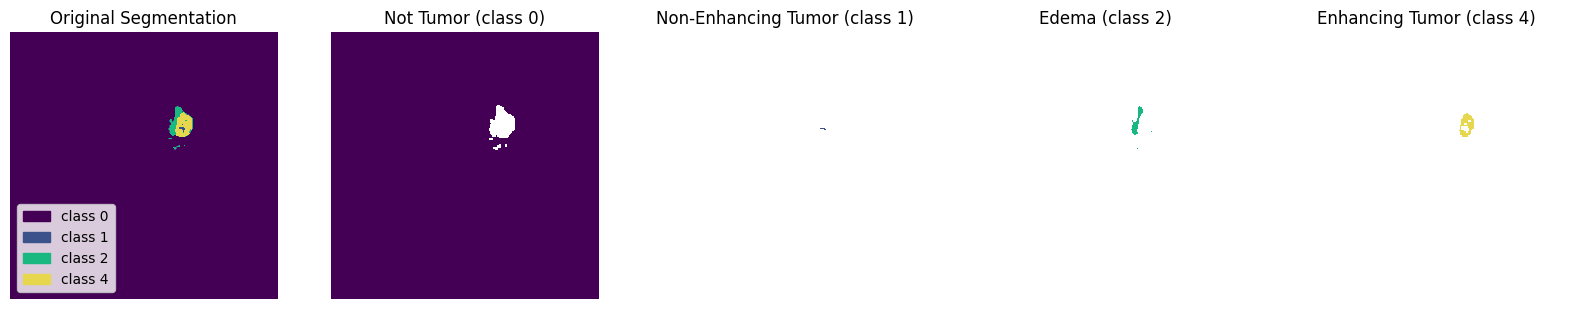

In [13]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')
ax[0].axis('off')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')
ax[1].axis('off')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')
ax[2].axis('off')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')
ax[3].axis('off')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')
ax[4].axis('off')

plt.show()

### **Summary of Our Data Exploration**  

- **Modalities:** Each patient scan includes 4 types (T1, T1CE, T2, and FLAIR) along with a segmentation map showing tumor areas.  
- **Selected Modalities:** We’ll use **T1CE and FLAIR** since they provide the most useful contrast and anatomical details.  
- **3D Images:** The scans are **3D**, made up of **2D slices** viewed from different planes.  
- **Useful Slices:** Not all slices contain meaningful information. We’ll focus on the **middle section (slices 50 to -50)**, but this range can be adjusted if needed.  
- **Segmentation Classes:** There are **1 to 4 tumor classes**. Since **class 3 is missing**, we’ll merge **class 4 into class 3** for consistency.  
- **Background Class:** The **background (class 0)** is dominant. To avoid losing important details, we won’t crop the images.  

# 2. Split the Dataset

To train and evaluate our model effectively, we need to split our dataset into three parts: the training set (70-80%) for training the model, the validation set (10-15%) for tuning hyperparameters and preventing overfitting, and the test set (10-15%) for evaluating the final model's performance. We can use random splitting to divide the data or stratified splitting to maintain the same class distribution across sets, which is particularly useful for imbalanced datasets. Properly splitting the dataset ensures that our model is robust and performs well on unseen data.


In [14]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(training_data_path) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [15]:
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


# 3. Data Generator

In [16]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [17]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(training_data_path, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

### Preprocessing Steps Summary

- **Data Generator:** Utilized to process and send data to the neural network without overloading memory.
- **Epoch Handling:** For each epoch, the model processes 250 samples from the training dataset.
- **Sample Analysis:** Each sample consists of 150 slices (100 slices each from two modalities) resized to (128, 128).
- **Data Shapes:**
  - **X Array:** Shape (128, 128, 100, 2) for input images.
  - **Ground Truth (y):** One-Hot encoded segmentation with shape (100, 128, 128, 4).

This preprocessing setup ensures efficient data handling and preparation for training the neural network.

# 4. Preparing data & Displaying Some Images

In [18]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

2025-06-17 06:41:40.655725: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


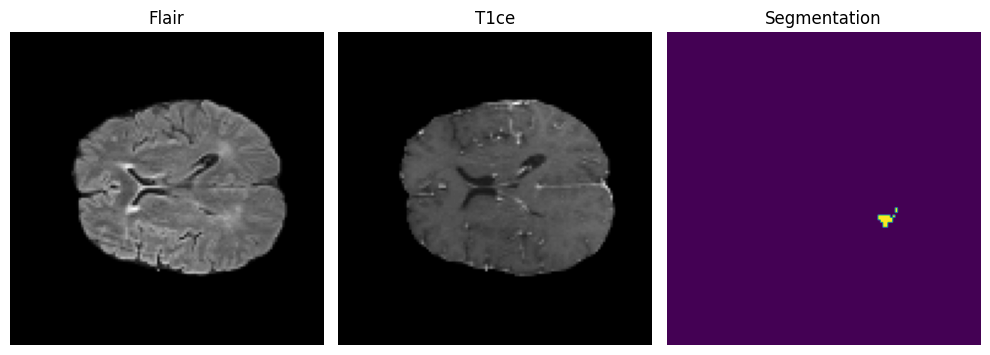

In [19]:
# function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


# 5. Model Building

In [20]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)